# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import pandas as pd
import seaborn as sns
# % matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Check and understand the datasets

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [6]:
print("Null percentage:\n",profile.isna().mean())
print("Null counts:\n",profile.isna().sum())

Null percentage:
 gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64
Null counts:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

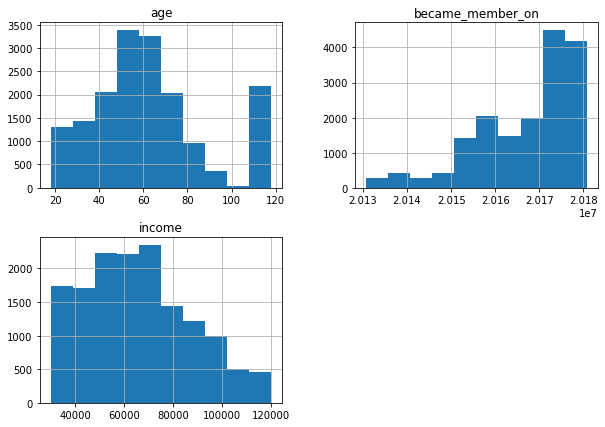

In [7]:
fig,ax = plt.subplots(1)
fig.set_size_inches(10,7)
profile.hist(ax=ax)

Explore some null values

In [8]:
profile[profile['gender'].isna()].head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


It's weird that samples of where we don't have values for gender age is 118 and income is also null

Assumption: These people don't want to share their personal information, thus age of 118 might be system generated age  

In [9]:
missing_gender = profile[profile['gender'].isna()]
# missing_gender.head(2)
print(missing_gender.isna().sum(),'\n',"=="*40)
missing_gender.age.value_counts()

# Those with null gender are the with null income and, all of them are put as age of 118

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64 


118    2175
Name: age, dtype: int64

These group may need to be removed when we do analysis based on gender, age and, income

In [10]:
profile['register_date'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['have_pi'] = np.where(profile['gender'].isna(), 0, 1)
profile.head(2)

,gender,age,id,became_member_on,income,register_date,have_pi
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,1


In [11]:
print(f"First register: {profile['register_date'].min()}\nLatest register: {profile['register_date'].max()}")

First register: 2013-07-29 00:00:00
Latest register: 2018-07-26 00:00:00


In [12]:
transcript.info()
# There're no null values in this dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [13]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [14]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Seems like the actual transactions are blended with offer. Let's try to seperate them from one another first

In [15]:
sales_trans = transcript.query("event == 'transaction'")
offer_trans = transcript.query("event != 'transaction'")
sales_trans.head(3)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0


In [16]:
# Check whether there are any value that have more key than just amount

s_value_key = []
printmsg = ""

for val in sales_trans['value']:
    if len(val.keys()) > 1:
        printmsg = "There are multiple keys values"
    for k_name in val.keys():
        if k_name not in s_value_key:
            s_value_key.append(k_name)
        else:
            pass

print(printmsg)
s_value_key

['amount']

In [17]:
sales_trans['sales'] = sales_trans['value'].apply(lambda x: x['amount'])
sales_trans.head(2)

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,person,event,value,time,sales
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56


In [18]:
offer_trans.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [19]:
offer_trans['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [20]:
offer_trans['vk_count'] = offer_trans['value'].apply(lambda x: len(x.keys()))
offer_trans.groupby(['event', 'vk_count']).count()['value']

# Only offer completed have to keys

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


event            vk_count
offer completed  2           33579
offer received   1           76277
offer viewed     1           57725
Name: value, dtype: int64

In [21]:
def get_offer_id(rw):
    if rw['event'] == 'offer completed':
        return rw['value']['offer_id']
    else:
        return rw['value']['offer id']

In [22]:
offer_trans['offer_id'] = offer_trans.apply(lambda x: get_offer_id(x), axis=1)
offer_trans['rewards'] = np.nan
offer_trans.loc[offer_trans['event']=='offer completed', 'rewards'] = offer_trans.loc[offer_trans['event']=='offer completed', 'value'].apply(lambda x: x['reward'])
# offer_trans.head(

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\racha\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [23]:
offer_trans[offer_trans['event']=='offer completed'].head(2)

,person,event,value,time,vk_count,offer_id,rewards
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,2,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [24]:
# Checking whether rewards in transaction align with portfolio or not
offer_trans.query("event == 'offer completed'")[['offer_id', 'rewards']].drop_duplicates().sort_values('offer_id', ascending=True)

,offer_id,rewards
14634,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
12721,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
12658,2906b810c7d4411798c6938adc9daaa5,2.0
12697,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
12679,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12744,f19421c1d4aa40978ebb69ca19b0e20d,5.0
12672,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [25]:
portfolio.sort_values('id', ascending=True)

,reward,channels,difficulty,duration,offer_type,id
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4


In [26]:
# Check if any offer id not in portfolio
offer_trans.loc[~offer_trans['offer_id'].isin(portfolio['id']), 'offer_id'].unique()

array([], dtype=object)

In [27]:
offer_trans.head(3)

,person,event,value,time,vk_count,offer_id,rewards
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,2906b810c7d4411798c6938adc9daaa5,NaN


In [28]:
all_chan=[]
for vals in portfolio.channels:
    for val in vals:
        if val not in all_chan:
            all_chan.append(val)
        else:
            pass
all_chan
for channel in all_chan:
    portfolio[channel] = np.where(portfolio['channels'].astype('str').str.contains(channel),1,0)
portfolio.head()
    

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


By natural sequences customer should : 
### Receive ==> View ==> Complete

In [29]:
offer_trans['po_key'] = offer_trans[['person','offer_id']].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
offer_trans.sort_values(by=['person', 'time'], ascending=[True, True]).head(5)

,person,event,value,time,vk_count,offer_id,rewards,po_key
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,1,5a8bc65990b245e5a138643cd4eb9837,NaN,0009655768c64bdeb2e877511632db8f-5a8bc65990b24...
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,1,5a8bc65990b245e5a138643cd4eb9837,NaN,0009655768c64bdeb2e877511632db8f-5a8bc65990b24...
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,1,3f207df678b143eea3cee63160fa8bed,NaN,0009655768c64bdeb2e877511632db8f-3f207df678b14...
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,1,3f207df678b143eea3cee63160fa8bed,NaN,0009655768c64bdeb2e877511632db8f-3f207df678b14...
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0009655768c64bdeb2e877511632db8f-f19421c1d4aa4...


In [31]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [32]:
cleanned_offer = offer_trans.query("event == 'offer received'")
cleanned_offer = cleanned_offer.merge(portfolio.drop(columns=['channels']),
                                      how='left',
                                      left_on=['offer_id'],
                                      right_on=['id']).drop(columns=['id'])
cleanned_offer = cleanned_offer.rename(columns={'time': 'time_start'})
cleanned_offer['valid_until'] = cleanned_offer['time_start'] + 24*cleanned_offer['duration'] 
cleanned_offer.head(3)

,person,event,value,time_start,vk_count,offer_id,rewards,po_key,reward,difficulty,duration,offer_type,email,mobile,social,web,valid_until
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,5,5,7,bogo,1,1,0,1,168
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,5,20,10,discount,1,0,0,1,240
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,2906b810c7d4411798c6938adc9daaa5,NaN,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,2,10,7,discount,1,1,0,1,168


In [33]:
from tqdm import tqdm

Let's use join to merge this 2 table instead

In [34]:
# Get view status first

cleanned_offer = cleanned_offer.merge(
    offer_trans.query("event == 'offer viewed'")[['event', 'time', 'po_key']].rename(columns={"event":"v_event", "time":'v_time', "po_key": "v_po_key"}),
    how='left',
    left_on='po_key',
    right_on='v_po_key'
    )
# cleanned_offer['same_key_next_received_time'] = cleanned_offer.groupby('po_key')['time_start'].shift(-1)

# Filter out invalid join
cleanned_offer = cleanned_offer.loc[
    ((cleanned_offer['v_time'].isna()) |
    ((cleanned_offer['v_time']>=cleanned_offer['time_start']) & (cleanned_offer['v_time']<=cleanned_offer['valid_until'])))
    ]
cleanned_offer.head(10)

# Overlapping campaigns will create duplications but for simplicity sake, we'll keep only first record to  
cleanned_offer = cleanned_offer.drop_duplicates(subset=['po_key', 'time_start'], keep='first') 


cleanned_offer['is_viewed'] = np.where((cleanned_offer['v_time'].isna()) , 0, 1)
cleanned_offer = cleanned_offer.drop(columns=['v_event', 'v_po_key', 'rewards'])

# # Get complete status

cleanned_offer = cleanned_offer.merge(
    offer_trans.query("event == 'offer completed'")[['event', 'time', 'rewards','po_key']].rename(columns={"event":"c_event", "time":'c_time', "po_key": "c_po_key"}),
    how='left',
    left_on='po_key',
    right_on='c_po_key'
    )

cleanned_offer = cleanned_offer.loc[
    ((cleanned_offer['c_time'].isna()) |
    ((cleanned_offer['c_time']>=cleanned_offer['time_start']) & (cleanned_offer['c_time']<=cleanned_offer['valid_until'])))
    ]

cleanned_offer['is_completed'] = np.where(cleanned_offer['c_time'].isna(), 0, 1)
cleanned_offer = cleanned_offer.drop(columns=['c_event', 'c_po_key'])

# Joining condition above also allow viewing offer after completed ==> Overlapping campaign let's remove them too
cleanned_offer = cleanned_offer.query("~(v_time > c_time)")
cleanned_offer = cleanned_offer.drop_duplicates(subset=['po_key', 'time_start', 'v_time'], keep='first') 
cleanned_offer.head(5)



,person,event,value,time_start,vk_count,offer_id,po_key,reward,difficulty,duration,offer_type,email,mobile,social,web,valid_until,v_time,is_viewed,c_time,rewards,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,5,5,7,bogo,1,1,0,1,168,6.0,1,132.0,5.0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,5,20,10,discount,1,0,0,1,240,6.0,1,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,2,10,7,discount,1,1,0,1,168,18.0,1,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e374...,2,10,10,discount,1,1,1,1,240,12.0,1,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a694...,10,10,5,bogo,1,1,1,1,120,84.0,1,NaN,NaN,0


In [35]:
# cleanned_offer.groupby('po_key')['time_start'].shift(-1)

In [36]:
# Check rewards error
# cleanned_offer.query("~rewards.isnull() and rewards != reward", engine="python").head()

# We should drop rewards in this case 
cleanned_offer = cleanned_offer.drop(columns=['rewards', 'value', 'vk_count', 'event'])

# rename and rearrange columns
cleanned_offer = cleanned_offer.rename(columns={'time_start': 'r_time'})
cleanned_offer['actual_end_time'] = cleanned_offer[['c_time', 'valid_until']].min(axis=1)
cleanned_offer = cleanned_offer[['person',  'offer_id', 'po_key', 'offer_type', 'reward', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web',
       'r_time', 'valid_until', 'v_time',  'c_time', 'actual_end_time','is_viewed', 'is_completed']]

cleanned_offer.head()


,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,discount,2,10,7,1,1,0,1,0,168,18.0,NaN,168.0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e374...,discount,2,10,10,1,1,1,1,0,240,12.0,NaN,240.0,1,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a694...,bogo,10,10,5,1,1,1,1,0,120,84.0,NaN,120.0,1,0


Looking at promotion itself whether type/ reward, difficulty and, duration individually impact completion rate on not across all/aware/unaware

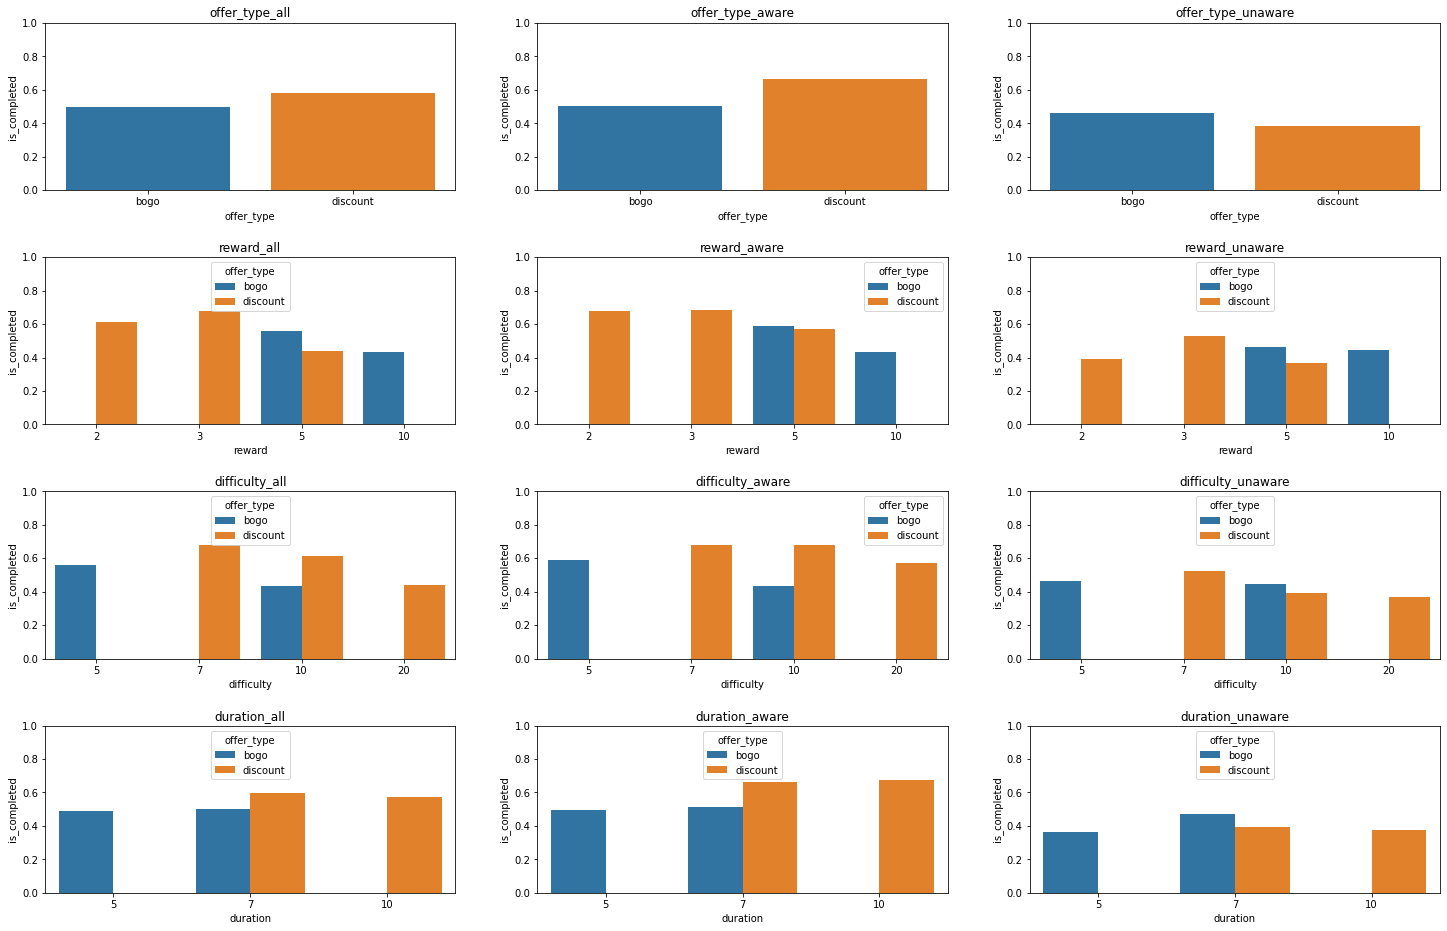

In [37]:
fig,ax = plt.subplots(4,3)
fig.set_size_inches(25,16)
fig.subplots_adjust(hspace=0.4)
dataset_dict = {0:'all', 1:'aware', 2:'unaware'}
aware = cleanned_offer.query("is_viewed == 1 & offer_type != 'informational'")
unaware = cleanned_offer.query("is_viewed != 1 & offer_type != 'informational'")
for idx, col in enumerate(['offer_type', 'reward', 'difficulty', 'duration']):
    for j,df in zip(np.arange(4),[cleanned_offer.query("offer_type != 'informational'"),aware, unaware]):
        if idx == 0:
            sns.barplot(data=df.groupby(by=[col], as_index=False)['is_completed'].mean(), x=col, y='is_completed', ax=ax[idx,j])
        else:
            sns.barplot(data=df.groupby(by=[col, 'offer_type'], as_index=False)['is_completed'].mean(), x=col, y='is_completed', hue='offer_type', hue_order=['bogo','discount'],  ax=ax[idx,j])
        ax[idx,j].set_title(f"{col}_{dataset_dict[j]}", fontsize=12)
        ax[idx,j].set_ylim(0,1)
        
    

### Observation from charts above:

- Concious users tend to complete the campaigns than those who don't
- Concious charts look similar to All chart than unawared <Hypothesis: Users are more likely to be concious about the campaign>
- Duration show expected results: The longer campaign the higher success rate it is <Easier to completed>
- Difficulty and Rewards are giving quite inclusive result. Theorhetical their relationship to success rate should be Inverse and Positive respectively ==> Maybe we shouldn't consider this separatedly   

In [38]:
# Percentage of campaigns awared
print(f"Percentage of campaigns awared is viewed around: {cleanned_offer['is_viewed'].mean():.4f}")

cleanned_offer.groupby('is_viewed').agg(
    {'is_completed':['mean', 'sum', 'count']})['is_completed'].rename(columns={'mean':'success_rate', 'sum': 'success_count','count':'total_campaign'})

Percentage of campaigns awared is viewed around: 0.7659


,success_rate,success_count,total_campaign
is_viewed,,,
0,0.311182,4870,15650
1,0.465957,23864,51215


In [39]:
from sklearn.preprocessing import MinMaxScaler

Let's try to engineer Reward, Difficulty and, Duration to get single value like campaign attractiveness

In [40]:
cleanned_offer['reward_input_ratio'] = cleanned_offer['reward']/cleanned_offer['difficulty']
cleanned_offer['reward_input_ratio'] = np.round(cleanned_offer['reward_input_ratio'],2)

In [41]:
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(cleanned_offer[['reward', 'duration', 'difficulty']]),
    columns= [x+"_scaled" for x in ['reward', 'duration', 'difficulty']],
    index= cleanned_offer.index
    )
cleanned_offer = pd.concat([cleanned_offer,scaled_data], axis=1)
cleanned_offer['campaign_attractiveness'] = cleanned_offer.reward_scaled - cleanned_offer.difficulty_scaled + cleanned_offer.duration_scaled
cleanned_offer['campaign_attractiveness'] = cleanned_offer['campaign_attractiveness'].apply(lambda x: round(x, 4))
cleanned_offer['easiness_to_completed'] = np.round(cleanned_offer['duration_scaled']/cleanned_offer['difficulty_scaled'],4)
cleanned_offer.head()

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,discount,2,10,7,1,1,0,1,0,168,18.0,NaN,168.0,1,0,0.20,0.2,0.571429,0.50,0.2714,1.1429
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e374...,discount,2,10,10,1,1,1,1,0,240,12.0,NaN,240.0,1,0,0.20,0.2,1.000000,0.50,0.7000,2.0000
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a694...,bogo,10,10,5,1,1,1,1,0,120,84.0,NaN,120.0,1,0,1.00,1.0,0.285714,0.50,0.7857,0.5714


In [42]:
cleanned_offer['reward_input_ratio'] = cleanned_offer['reward_input_ratio'].fillna(0)
cleanned_offer['easiness_to_completed'] = cleanned_offer['easiness_to_completed'].fillna(float('inf'))
cleanned_offer['pro_name'] = cleanned_offer[['offer_type', 'reward', 'difficulty', 'duration']].astype(str).apply('-'.join, axis=1)

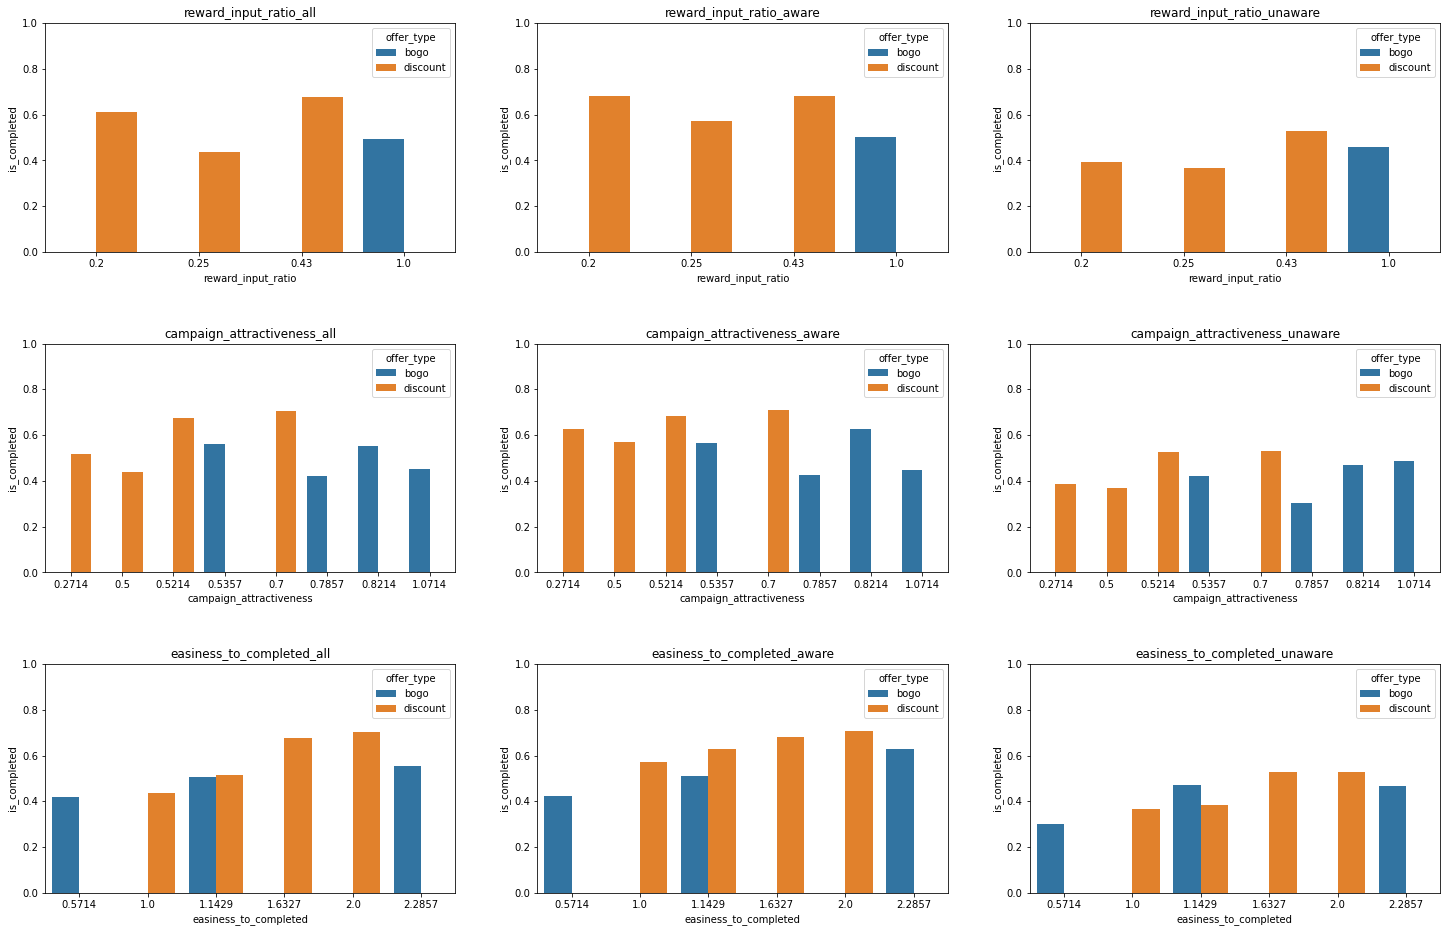

In [43]:
fig,ax = plt.subplots(3,3)
fig.set_size_inches(25,16)
fig.subplots_adjust(hspace=0.4)
dataset_dict = {0:'all', 1:'aware', 2:'unaware'}
aware = cleanned_offer.query("is_viewed == 1 & offer_type != 'informational'")
unaware = cleanned_offer.query("is_viewed != 1 & offer_type != 'informational'")
for idx, col in enumerate(['reward_input_ratio', 'campaign_attractiveness', 'easiness_to_completed']):
    for j,df in zip(np.arange(4),[cleanned_offer.query("offer_type != 'informational'"),aware, unaware]):
        # sns.barplot(data=df.groupby(by=[col], as_index=False)['is_completed'].mean(), x=col, y='is_completed', ax=ax[idx,j])
        sns.barplot(data=df.groupby(by=[col, 'offer_type'], as_index=False)['is_completed'].mean(), x=col, y='is_completed', hue='offer_type', hue_order=['bogo', 'discount'],ax=ax[idx,j])
        # ax[idx,j].tick_params(labelrotation=45)
        # ax[idx,j].set_xticklabels(labels=df[col].unique(), rotation=45)
        ax[idx,j].set_title(f"{col}_{dataset_dict[j]}", fontsize=12)
        ax[idx,j].set_ylim(0,1)

        
    

Observations:
- Seems like easiness to completed is the most critical factor to determine whether a campaign will be completed or not
- Reward doesn't seem to have much of an impact on campaign completeness ==> Maybe BOGO might not work as reward is not effective in this sense | Have to also check in term of uplift or ROI 

In [44]:
portfolio =  portfolio.merge(cleanned_offer[['offer_id', 'reward_input_ratio','campaign_attractiveness']].drop_duplicates(),
                             how='left', 
                             left_on=['id'],
                             right_on=['offer_id']).drop(columns=['offer_id'])
portfolio.sort_values('offer_type')

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,reward_input_ratio,campaign_attractiveness
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.00,1.0714
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.00,0.7857
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.00,0.8214
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1.00,0.5357
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.25,0.5000
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0.43,0.5214
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0.20,0.7000
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0.20,0.2714
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.00,0.1429
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0.00,0.0000


In [45]:
sales_trans = sales_trans.drop(columns=['value'])
sales_trans['trans_id'] = sales_trans['person'] + "-" + sales_trans['time'].astype('str')
sales_trans.head(2)

,person,event,time,sales,trans_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,02c083884c7d45b39cc68e1314fec56c-0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f-0


In [46]:
sales_trans.trans_id.value_counts().head(10)

02c083884c7d45b39cc68e1314fec56c-0      1
dd9594e6ca65431db74456ae27a298e4-504    1
7e9b24bdae7244bb87dfc730bea9112e-504    1
b8a1911efeae48e58762b98395014a8c-504    1
187dbd09f0f24bdc8c3089dfeed3f847-504    1
9bc7ee251eec46ffaf81c1906792bef6-504    1
37e4b2119d754558bebf92f3a06b9650-504    1
9d48e17bab4d42d28c7da398858ce8c1-504    1
21ee2f128a5948728158fb28b5761bb9-504    1
4edd4c3dc0e64b4885e61b1d20267e67-504    1
Name: trans_id, dtype: int64

In [47]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,reward_input_ratio,campaign_attractiveness
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.00,1.0714
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.00,0.7857
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.00,0.1429
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.00,0.8214
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.25,0.5000
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0.43,0.5214
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0.20,0.7000
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0.00,0.0000
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1.00,0.5357
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0.20,0.2714


In [48]:
# Trans pro will contain transactions that happenned users aware of the campaign and until the campaign is completed/expired 
trans_pro = sales_trans.copy()
trans_pro = trans_pro.merge(cleanned_offer.query("is_viewed == 1"),
                            how='inner',
                            left_on='person',
                            right_on='person')

# Only valid trans_pro 
trans_pro = trans_pro.query("time >= v_time & time<=actual_end_time")
trans_pro.head()

,person,event,time,sales,trans_id,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,02c083884c7d45b39cc68e1314fec56c-0,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,02c083884c7d45b39cc68e1314fec56c-6,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7
2,02c083884c7d45b39cc68e1314fec56c,transaction,12,4.56,02c083884c7d45b39cc68e1314fec56c-12,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7
3,02c083884c7d45b39cc68e1314fec56c,transaction,84,1.53,02c083884c7d45b39cc68e1314fec56c-84,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7
4,02c083884c7d45b39cc68e1314fec56c,transaction,90,0.50,02c083884c7d45b39cc68e1314fec56c-90,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7


In [49]:
trans_norm  = sales_trans.loc[~sales_trans['trans_id'].isin(trans_pro['trans_id'])]

In [50]:
sales_trans[sales_trans['trans_id']=='edc7b04392144da9979f3077095f268a-504']

,person,event,time,sales,trans_id
218017,edc7b04392144da9979f3077095f268a,transaction,504,0.78,edc7b04392144da9979f3077095f268a-504


In [51]:
trans_pro[trans_pro['trans_id']=='e211ccfbd319454490cbfbeeb6f3da5e-576'].head(10)

,person,event,time,sales,trans_id,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
424430,e211ccfbd319454490cbfbeeb6f3da5e,transaction,576,3.94,e211ccfbd319454490cbfbeeb6f3da5e-576,fafdcd668e3743c1bb461111dcafc2a4,e211ccfbd319454490cbfbeeb6f3da5e-fafdcd668e374...,discount,2,10,10,1,1,1,1,336,576,372.0,NaN,576.0,1,0,0.2,0.2,1.000000,0.5,0.7000,2.0000,discount-2-10-10
424431,e211ccfbd319454490cbfbeeb6f3da5e,transaction,576,3.94,e211ccfbd319454490cbfbeeb6f3da5e-576,2906b810c7d4411798c6938adc9daaa5,e211ccfbd319454490cbfbeeb6f3da5e-2906b810c7d44...,discount,2,10,7,1,1,0,1,408,576,426.0,NaN,576.0,1,0,0.2,0.2,0.571429,0.5,0.2714,1.1429,discount-2-10-7
424432,e211ccfbd319454490cbfbeeb6f3da5e,transaction,576,3.94,e211ccfbd319454490cbfbeeb6f3da5e-576,5a8bc65990b245e5a138643cd4eb9837,e211ccfbd319454490cbfbeeb6f3da5e-5a8bc65990b24...,informational,0,0,3,1,1,1,0,504,576,510.0,NaN,576.0,1,0,0.0,0.0,0.000000,0.0,0.0000,inf,informational-0-0-3


In [52]:
cleanned_offer.head(2)

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000,discount-5-20-10


In [53]:
cleanned_offer.columns

Index(['person', 'offer_id', 'po_key', 'offer_type', 'reward', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'r_time', 'valid_until',
       'v_time', 'c_time', 'actual_end_time', 'is_viewed', 'is_completed',
       'reward_input_ratio', 'reward_scaled', 'duration_scaled',
       'difficulty_scaled', 'campaign_attractiveness', 'easiness_to_completed',
       'pro_name'],
      dtype='object')

Let's see whether aware of the campaign help uplift or increase frequency of transaction or not 

It's best to compare pro_period to non-pro, however to flag non-pro period accurately is complicated. We can compared pro-period with their lifetime instead

In [54]:
on_pro_period = cleanned_offer[['person', 'offer_id', 'v_time','actual_end_time']].copy().sort_values(['person', 'v_time'])
on_pro_period = on_pro_period.dropna(subset=['v_time'])
on_pro_period['time_on_pro'] = on_pro_period['actual_end_time'] - on_pro_period['v_time']
on_pro_period.head(10)

,person,offer_id,v_time,actual_end_time,time_on_pro
16529,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.0,240.0,48.0
30113,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.0,432.0,60.0
17061,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216.0,288.0,72.0
71985,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630.0,696.0,66.0
3312,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,6.0,96.0,90.0
16876,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,186.0,252.0,66.0
30440,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,354.0,408.0,54.0
44265,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,432.0,576.0,144.0
58080,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,516.0,576.0,60.0
2052,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,12.0,54.0,42.0


In [55]:
time_on_stb = sales_trans.groupby(by=['person']).agg({'time':['min', 'max']})['time'].reset_index()
time_on_stb['total_time_spent'] = time_on_stb['max'] - time_on_stb['min']
time_on_stb.head()

,person,min,max,total_time_spent
0,0009655768c64bdeb2e877511632db8f,228,696,468
1,00116118485d4dfda04fdbaba9a87b5c,294,474,180
2,0011e0d4e6b944f998e987f904e8c1e5,132,654,522
3,0020c2b971eb4e9188eac86d93036a77,54,708,654
4,0020ccbbb6d84e358d3414a3ff76cffd,42,672,630


In [56]:
on_pro_period[on_pro_period['person']=='9d3cf96704194f0ba87295d3b499b9de']

,person,offer_id,v_time,actual_end_time,time_on_pro
13163,9d3cf96704194f0ba87295d3b499b9de,9b98b8c7a33c4b65b9aebfe6a799e6d9,48.0,168.0,120.0
26758,9d3cf96704194f0ba87295d3b499b9de,0b1e1539f2cc45b7b9fa7c272da2e1d7,186.0,408.0,222.0
40460,9d3cf96704194f0ba87295d3b499b9de,0b1e1539f2cc45b7b9fa7c272da2e1d7,342.0,576.0,234.0
54357,9d3cf96704194f0ba87295d3b499b9de,2906b810c7d4411798c6938adc9daaa5,408.0,576.0,168.0
68122,9d3cf96704194f0ba87295d3b499b9de,fafdcd668e3743c1bb461111dcafc2a4,510.0,744.0,234.0
81843,9d3cf96704194f0ba87295d3b499b9de,2906b810c7d4411798c6938adc9daaa5,600.0,744.0,144.0


In [57]:
total_onpro_by_person = on_pro_period.groupby(by=['person'], as_index=False)['time_on_pro'].sum()
total_onpro_by_person.sort_values('time_on_pro', ascending=False).head(10)

,person,time_on_pro
10328,9d3cf96704194f0ba87295d3b499b9de,1122.0
6579,6543fc9d9aea47d08f64b465df939c76,1116.0
15555,ee916f63db3e4148a0e0cfbf7a42e795,1098.0
12389,bc98025ca6a1476887adb6ab925e8b0f,1074.0
8706,8582150967d2440e93a857b4ef460f43,1068.0
6850,690deebf33ba4269a28a33698417007d,1044.0
2881,2d54fa98743946f286e28acfd24cd4cd,1038.0
9591,928bb18c19d14eda9eea213a4ec94360,1020.0
1922,1e95b3bc9dd94d5aa14ec531ea948b89,1020.0
8689,8548baf4011c4e8b848d19cbe4010cfa,1014.0


In [58]:
person_time_master = time_on_stb.merge(total_onpro_by_person,
                                       how='left', 
                                       left_on='person',
                                       right_on='person')
# person_time_master['time_non_pro'] = person_time_master['total_time_spent']-person_time_master['time_on_pro']
person_time_master['on_protime_pct'] = np.round(person_time_master['time_on_pro']/person_time_master['total_time_spent'],4) 
person_time_master.head(4)

,person,min,max,total_time_spent,time_on_pro,on_protime_pct
0,0009655768c64bdeb2e877511632db8f,228,696,468,108.0,0.2308
1,00116118485d4dfda04fdbaba9a87b5c,294,474,180,138.0,0.7667
2,0011e0d4e6b944f998e987f904e8c1e5,132,654,522,414.0,0.7931
3,0020c2b971eb4e9188eac86d93036a77,54,708,654,126.0,0.1927


In [59]:
sales_trans['is_pro'] = np.where(sales_trans['trans_id'].isin(trans_pro['trans_id']),1,0)
spending_by_person = sales_trans.groupby(by=['person','is_pro']).agg({'sales':['sum','mean'], 'trans_id':'count'})[['sales','trans_id']].unstack()
spending_by_person = spending_by_person.fillna(0)
spending_by_person = spending_by_person.reset_index()
spending_by_person.columns = ['person', 'sales_nonpro', 'sales_pro', 'avg_sales_nonpro', 'avg_sales_pro', 'trans_nonpro_count', 'trans_pro_count']
spending_by_person['sales_all']  = spending_by_person['sales_nonpro']+spending_by_person['sales_pro']
spending_by_person['trans_all'] = spending_by_person['trans_nonpro_count']+spending_by_person['trans_pro_count']
spending_by_person['avg_sales_all'] = spending_by_person['sales_all']/spending_by_person['trans_all']
spending_by_person.head()

,person,sales_nonpro,sales_pro,avg_sales_nonpro,avg_sales_pro,trans_nonpro_count,trans_pro_count,sales_all,trans_all,avg_sales_all
0,0009655768c64bdeb2e877511632db8f,96.87,30.73,16.145000,15.365000,6.0,2.0,127.60,8.0,15.950000
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0.00,1.363333,0.000000,3.0,0.0,4.09,3.0,1.363333
2,0011e0d4e6b944f998e987f904e8c1e5,45.48,33.98,15.160000,16.990000,3.0,2.0,79.46,5.0,15.892000
3,0020c2b971eb4e9188eac86d93036a77,161.99,34.87,26.998333,17.435000,6.0,2.0,196.86,8.0,24.607500
4,0020ccbbb6d84e358d3414a3ff76cffd,58.68,95.37,11.736000,13.624286,5.0,7.0,154.05,12.0,12.837500


In [60]:
compare_proall = person_time_master.merge(spending_by_person,
                                          how='left', 
                                          left_on='person',
                                          right_on='person')
compare_proall['freq_per_hr_all'] = compare_proall['trans_all']/compare_proall['total_time_spent']
compare_proall['freq_per_hr_pro'] = compare_proall['trans_pro_count']/compare_proall['time_on_pro']
compare_proall.head()
# compare_proall['sales_per_hr_all'] = compare_proall['sales_all']/compare_proall['total_time_spent']
# compare_proall['sales_per_hr_pro'] = compare_proall['sales_pro']/compare_proall['time_on_pro']

,person,min,max,total_time_spent,time_on_pro,on_protime_pct,sales_nonpro,sales_pro,avg_sales_nonpro,avg_sales_pro,trans_nonpro_count,trans_pro_count,sales_all,trans_all,avg_sales_all,freq_per_hr_all,freq_per_hr_pro
0,0009655768c64bdeb2e877511632db8f,228,696,468,108.0,0.2308,96.87,30.73,16.145000,15.365000,6.0,2.0,127.60,8.0,15.950000,0.017094,0.018519
1,00116118485d4dfda04fdbaba9a87b5c,294,474,180,138.0,0.7667,4.09,0.00,1.363333,0.000000,3.0,0.0,4.09,3.0,1.363333,0.016667,0.000000
2,0011e0d4e6b944f998e987f904e8c1e5,132,654,522,414.0,0.7931,45.48,33.98,15.160000,16.990000,3.0,2.0,79.46,5.0,15.892000,0.009579,0.004831
3,0020c2b971eb4e9188eac86d93036a77,54,708,654,126.0,0.1927,161.99,34.87,26.998333,17.435000,6.0,2.0,196.86,8.0,24.607500,0.012232,0.015873
4,0020ccbbb6d84e358d3414a3ff76cffd,42,672,630,174.0,0.2762,58.68,95.37,11.736000,13.624286,5.0,7.0,154.05,12.0,12.837500,0.019048,0.040230


(0.0, 0.2)

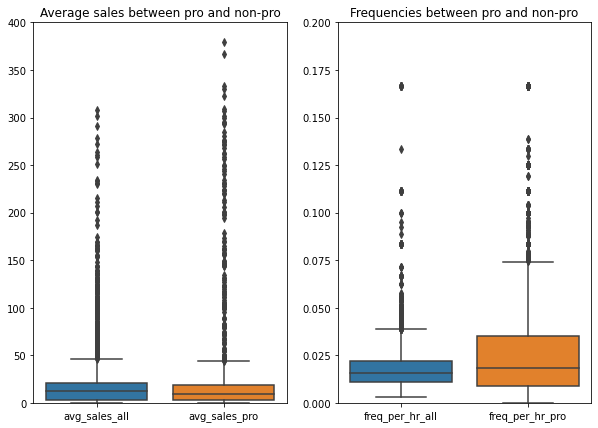

In [61]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,7)
l_fig = sns.boxplot(data =compare_proall[['avg_sales_all','avg_sales_pro']], ax=ax[0])
l_fig.set_ylim(0,400)
r_fig = sns.boxplot(data =compare_proall[['freq_per_hr_all','freq_per_hr_pro']], ax=ax[1])
l_fig.set_title("Average sales between pro and non-pro")
r_fig.set_title("Frequencies between pro and non-pro")
r_fig.set_ylim(0,0.2)


Seems like pro or not doesn't impact much on sales per transaction but it increase frequencies

Let's use all metrics as baseline and find out how each campaign affect these 2 metrics

In [62]:
trans_pro.head(2)

,person,event,time,sales,trans_id,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,02c083884c7d45b39cc68e1314fec56c-0,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,02c083884c7d45b39cc68e1314fec56c-6,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c-ae264e3637204...,bogo,10,10,7,1,1,1,0,0,168,0.0,NaN,168.0,1,0,1.0,1.0,0.571429,0.5,1.0714,1.1429,bogo-10-10-7


In [63]:
trans_pro_agg_campaign = trans_pro.groupby(
    by=[
    'person','po_key','offer_type', 'reward', 'difficulty', 'duration','r_time', 'valid_until', 'v_time',
       'actual_end_time', 'is_viewed', 'is_completed', 'reward_input_ratio',
       'reward_scaled', 'duration_scaled', 'difficulty_scaled',
       'campaign_attractiveness', 'easiness_to_completed'
    ], as_index=False)[['sales', 'time']].agg({'sales':'sum', 'time': 'count'}).rename(columns={'time':'frequency'})
trans_pro_agg_campaign.head(2)

,person,po_key,offer_type,reward,difficulty,duration,r_time,valid_until,v_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,sales,frequency
0,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f-3f207df678b14...,informational,0,0,4,336,432,372.0,432.0,1,0,0.0,0.0,0.142857,0.0,0.1429,inf,8.57,1
1,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f-5a8bc65990b24...,informational,0,0,3,168,240,192.0,240.0,1,0,0.0,0.0,0.000000,0.0,0.0000,inf,22.16,1


Let's create pro name for simplicity sake

In [64]:
trans_pro_agg_campaign['pro_name'] = trans_pro_agg_campaign[['offer_type', 'reward', 'difficulty', 'duration']].astype(str).apply('-'.join, axis=1)
trans_pro_agg_campaign['awared_duration'] = trans_pro_agg_campaign['actual_end_time'] - trans_pro_agg_campaign['v_time']
trans_pro_agg_campaign['avg_sales'] = trans_pro_agg_campaign['sales']/trans_pro_agg_campaign['frequency']
trans_pro_agg_campaign['frequency_per_hrs'] = trans_pro_agg_campaign['frequency']/trans_pro_agg_campaign['awared_duration']
trans_pro_agg_campaign.head(2)

,person,po_key,offer_type,reward,difficulty,duration,r_time,valid_until,v_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,sales,frequency,pro_name,awared_duration,avg_sales,frequency_per_hrs
0,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f-3f207df678b14...,informational,0,0,4,336,432,372.0,432.0,1,0,0.0,0.0,0.142857,0.0,0.1429,inf,8.57,1,informational-0-0-4,60.0,8.57,0.016667
1,0009655768c64bdeb2e877511632db8f,0009655768c64bdeb2e877511632db8f-5a8bc65990b24...,informational,0,0,3,168,240,192.0,240.0,1,0,0.0,0.0,0.000000,0.0,0.0000,inf,22.16,1,informational-0-0-3,48.0,22.16,0.020833


In [65]:
compared_by_offers = compare_proall[['person', 'avg_sales_all', 'freq_per_hr_all']].rename(columns={'avg_sales_all':'avg_sales', 'freq_per_hr_all':'frequency_per_hrs'})
compared_by_offers['promotion'] = 'all'
# Use average sales of non-pro would make better representation
# non_pro_agg = trans_norm.groupby('person', as_index=False)['sales'].mean()
# compared_by_offers = compared_by_offers.merge(non_pro_agg,
#                         how='left', 
#                         left_on='person',
#                         right_on='person'
#                         )
# compared_by_offers['avg_sales'] = np.where(compared_by_offers['sales'].isna(), compared_by_offers['avg_sales'], compared_by_offers['avg_sales'])
# compared_by_offers = compared_by_offers.drop(columns=['sales'])
compared_by_offers = pd.concat(
    [compared_by_offers, 
    trans_pro_agg_campaign[['person', 'avg_sales', 'frequency_per_hrs','pro_name']].rename(columns={'pro_name':'promotion'})
    ], 
    axis=0)
compared_by_offers.head(2)

,person,avg_sales,frequency_per_hrs,promotion
0,0009655768c64bdeb2e877511632db8f,15.950000,0.017094,all
1,00116118485d4dfda04fdbaba9a87b5c,1.363333,0.016667,all


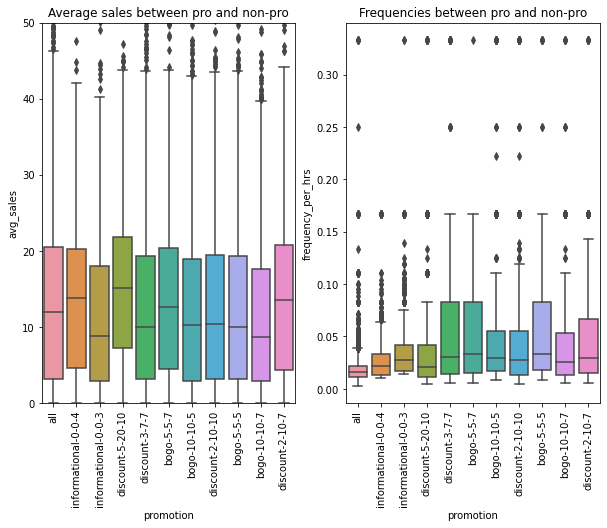

In [66]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,7)
sns.boxplot(data=compared_by_offers, x='promotion', y='avg_sales', ax=ax[0])
sns.boxplot(data=compared_by_offers, x='promotion', y='frequency_per_hrs', ax=ax[1])
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_ylim(0,50)
ax[1].tick_params(axis='x', labelrotation=90)
ax[0].set_title("Average sales between pro and non-pro")
ax[1].set_title("Frequencies between pro and non-pro")
plt.show()

As can be seen above: 
- Even though on all vs pro level some show that average spending doesn't change, some promotion do indeed have higher average sales per transaction
- Even informational message seems to also have an effect on visit frequencies

In [67]:
# overall_by_campaign = trans_pro_agg_campaign.groupby(by=['pro_name', 'is_completed'], as_index=False)[['sales', 'frequency', 'awared_duration']].agg({'sales':'mean', 'frequency':'sum', 'awared_duration':'sum'})
# overall_by_campaign['avg_frequency_per_hr'] = overall_by_campaign['frequency']/overall_by_campaign['awared_duration']
# overall_by_campaign

## Machine learning model parts

We going to develop model to predict how much each person going to spend in throughout a compaign and use that against baseline sales which will be calculated as `avg_sales_per_tranactions * avg_freq_per_hr * campaign_hrs` and cost(reward) to determine profitability and uplift

In [68]:
profile['mem_year']  = profile['register_date'].dt.year
# I'll impute lack of PI with UN for gender, age and income with median
profile['gender'] = profile['gender'].fillna('UN') 
profile['age'] = np.where(profile['age']==118, profile['age'].median(), profile['age'])
profile['income'] = profile['income'].fillna(profile['income'].median())
profile['age_band'] = pd.cut(profile['age'], bins=[0,20,40,60,80,1000], labels=['0-20', '21-40','41-60','61-80', '80+'], right=True)
profile['income_band'] = pd.cut(profile['income'], bins=np.arange(0,140000,20000), labels=['0-20k', '20-40k','40-60k','60-80k', '80-100k','100-120k'], right=True)
for col in ['gender','age_band','income_band', 'mem_year']:
    profile = pd.concat(
        [profile,
        pd.get_dummies(profile[col], prefix=col[:3], prefix_sep='_')
        ],
        axis=1
        )
profile.head()


,gender,age,id,became_member_on,income,register_date,have_pi,mem_year,age_band,income_band,gen_F,gen_M,gen_O,gen_UN,age_0-20,age_21-40,age_41-60,age_61-80,age_80+,inc_0-20k,inc_20-40k,inc_40-60k,inc_60-80k,inc_80-100k,inc_100-120k,mem_2013,mem_2014,mem_2015,mem_2016,mem_2017,mem_2018
0,UN,58.0,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,2017-02-12,0,2017,41-60,60-80k,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,1,2017,41-60,100-120k,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,UN,58.0,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,2018-07-12,0,2018,41-60,60-80k,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,1,2017,61-80,80-100k,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,UN,58.0,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,2017-08-04,0,2017,41-60,60-80k,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [69]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'register_date',
       'have_pi', 'mem_year', 'age_band', 'income_band', 'gen_F', 'gen_M',
       'gen_O', 'gen_UN', 'age_0-20', 'age_21-40', 'age_41-60', 'age_61-80',
       'age_80+', 'inc_0-20k', 'inc_20-40k', 'inc_40-60k', 'inc_60-80k',
       'inc_80-100k', 'inc_100-120k', 'mem_2013', 'mem_2014', 'mem_2015',
       'mem_2016', 'mem_2017', 'mem_2018'],
      dtype='object')

In [70]:
ml_profile = profile.drop(columns=['gender', 'age','became_member_on', 'mem_year','income', 'register_date','age_band', 'income_band'])
ml_profile.head(2)

,id,have_pi,gen_F,gen_M,gen_O,gen_UN,age_0-20,age_21-40,age_41-60,age_61-80,age_80+,inc_0-20k,inc_20-40k,inc_40-60k,inc_60-80k,inc_80-100k,inc_100-120k,mem_2013,mem_2014,mem_2015,mem_2016,mem_2017,mem_2018
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0610b486422d4921ae7d2bf64640c50b,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


Let's use latest campaign they participate for test set 2nd last and 3rd last for training set

In [71]:
test_ratio = 0.15 
test_size = math.ceil(0.15*cleanned_offer.shape[0])
train_df = cleanned_offer.iloc[:-test_size]
test_df = cleanned_offer.iloc[-test_size:]
train_df.head(2)

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000,discount-5-20-10


In [72]:
test_df.head(2)

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
69562,0607b32041f94d65a07835fc9a13416a,9b98b8c7a33c4b65b9aebfe6a799e6d9,0607b32041f94d65a07835fc9a13416a-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,576,744,NaN,588.0,588.0,0,1,1.0,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7
69563,479134f6760f4d69b5f368075ac1aca1,4d5c57ea9a6940dd891ad53e9dbe8da0,479134f6760f4d69b5f368075ac1aca1-4d5c57ea9a694...,bogo,10,10,5,1,1,1,1,576,696,600.0,696.0,696.0,1,1,1.0,1.0,0.285714,0.50,0.7857,0.5714,bogo-10-10-5


In [73]:
cleanned_offer = pd.concat([cleanned_offer,
                            pd.get_dummies(cleanned_offer['pro_name'], prefix='pro', prefix_sep='_')], 
                            axis=1)
cleanned_offer.head(3)

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,pro_informational-0-0-4
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7,0,0,0,1,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000,discount-5-20-10,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,discount,2,10,7,1,1,0,1,0,168,18.0,NaN,168.0,1,0,0.20,0.2,0.571429,0.50,0.2714,1.1429,discount-2-10-7,0,0,0,0,0,1,0,0,0,0


### Preparing historical transactions dataasd

In [74]:
# use function to find historical performance before the time of test
def find_pro_historical_data(pid:str, time_until:int):
    """
    output: dataframe contains historical data for ML model of the person up to specific time
    """

    # Find overall pro completion data 
    sam_df = cleanned_offer.query("person == @pid & r_time<=@time_until & actual_end_time<=@time_until")
    sam_agg =sam_df.groupby(by=['person'], as_index=False)[['offer_id','is_viewed', 'is_completed','pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
        'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
        'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
        'pro_informational-0-0-4']].agg(dict(zip(['offer_id','is_viewed', 'is_completed','pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
        'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
        'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
        'pro_informational-0-0-4'],['count', 'mean', 'mean', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum'])))
    sam_agg = sam_agg.rename(columns={'offer_id':'received_offer_counts', 'is_viewed': 'viewed_rates', 'is_completed':'completed_rates'})
    return sam_agg

def find_trans_historical_data(pid:str, time_until:int):
# Find spending related data 

# Fixing sam_trans in case the person don't have adequate data
    # sam_trans = sales_trans.query("person == @pid & time<= @time_until")
    sam_trans = sales_trans.query("time<= @time_until")

    st_agg1 = sam_trans.groupby(["person"], as_index=False)[['time']].agg({'time':['min','max']})
    st_agg1.columns = ['person','start_time', 'latest_time']
    st_agg2 = sam_trans.groupby(["person","is_pro"])[[ 'sales','trans_id']].agg({'sales':'mean', 'trans_id':'count'}).unstack()
    

    st_agg1 = st_agg1.query("person == @pid")
    st_agg2 = st_agg2.query("person == @pid") 
    st_agg2 = st_agg2.fillna(0)

    st_agg2['trans_pro_ratio'] = st_agg2['trans_id' ,1]/(st_agg2['trans_id' ,0]+st_agg2['trans_id' ,1])
    st_agg2['trans_count'] = st_agg2['trans_id' ,0]+st_agg2['trans_id' ,1]
    st_agg1.columns = ['person','start_time', 'latest_time']
    st_agg1['time_spent'] = st_agg1['latest_time'] - st_agg1['start_time']
    st_agg2.columns = ['avg_sales_norm', 'avg_sales_pro', 'tnp_count', 'tp_count', 'trans_pro_ratio', 'trans_count']
    st_agg2 = st_agg2.reset_index()
    # print(st_agg2.head(1))

    # st_agg2 = st_agg2.query("person == @pid")
    
    st_agg_interim = st_agg1.merge(st_agg2, how='inner', left_on='person', right_on='person')
    st_agg_interim['trans_per_hr'] = st_agg_interim['trans_count']/st_agg_interim['time_spent']
    st_agg_interim = st_agg_interim.drop(columns=['start_time', 'latest_time'])


    return st_agg_interim


def find_historical_data_merge_with_profile(trans_hist_df:pd.DataFrame, pro_hist_df:pd.DataFrame):

    st_agg_cmb = pro_hist_df.merge(trans_hist_df, how='inner', left_on='person', right_on='person')
    st_agg_cmb = st_agg_cmb.merge(ml_profile.rename(columns={'id':'person'}), how='left', left_on='person', right_on='person')
    return st_agg_cmb

def get_hist_full_data(pid:str, time_until:int):
    
    pro_hist = find_pro_historical_data(pid, time_until)
    trans_hist = find_trans_historical_data(pid, time_until)
    final_df =  find_historical_data_merge_with_profile(trans_hist, pro_hist)
    return final_df




### Latest offer received of every with more than one offer received will be used for training solution

In [76]:
last_date_by_person = train_df.groupby('person', as_index=False)[['r_time']].agg({'r_time': ['max','count']})
last_date_by_person.columns = ['person', 'latest_r_time', 'total_offer_received_count']
last_date_by_person.head(2)

,person,latest_r_time,total_offer_received_count
0,0009655768c64bdeb2e877511632db8f,336,2
1,00116118485d4dfda04fdbaba9a87b5c,168,1


In [77]:
last_date_by_person['total_offer_received_count'].value_counts()

4    5430
3    5419
2    2878
5    2342
1     744
6     108
Name: total_offer_received_count, dtype: int64

#### Find spending on each offer regardless of the status

In [78]:
spending_per_pro = sales_trans.copy()
spending_per_pro = cleanned_offer.merge(spending_per_pro,
                            how='left',
                            left_on='person',
                            right_on='person')

# Only valid trans_pro 
spending_per_pro = spending_per_pro.query("(time >= r_time & time<=actual_end_time) or time.isnull()", engine='python')
# spending_per_pro.head()
spending_per_pro = spending_per_pro.groupby(by=['person', 'offer_id','po_key', 'offer_type', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'social', 'web', 'r_time', 'valid_until', 'v_time', 'c_time',
       'actual_end_time', 'is_viewed', 'is_completed', 'reward_input_ratio',
       'reward_scaled', 'duration_scaled', 'difficulty_scaled',
       'campaign_attractiveness', 'easiness_to_completed', 'pro_name',
       'pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
       'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
       'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
       'pro_informational-0-0-4'], as_index=False, dropna=False)['sales'].sum()

spending_per_pro = cleanned_offer.merge(spending_per_pro[['person', 'r_time', 'sales']],
                                        how='left',
                                        left_on=['person','r_time'],
                                        right_on=['person','r_time'])
spending_per_pro = spending_per_pro[['person', 'offer_id','po_key', 'offer_type', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'social', 'web', 'r_time', 'valid_until', 'v_time', 'c_time',
       'actual_end_time', 'is_viewed', 'is_completed', 'reward_input_ratio',
       'reward_scaled', 'duration_scaled', 'difficulty_scaled',
       'campaign_attractiveness', 'easiness_to_completed', 'pro_name',
       'pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
       'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
       'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
       'pro_informational-0-0-4','sales']]
spending_per_pro.head()

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,pro_informational-0-0-4,sales
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7,0,0,0,1,0,0,0,0,0,0,19.89
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000,discount-5-20-10,0,0,0,0,0,0,0,1,0,0,1.09
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932-2906b810c7d44...,discount,2,10,7,1,1,0,1,0,168,18.0,NaN,168.0,1,0,0.20,0.2,0.571429,0.50,0.2714,1.1429,discount-2-10-7,0,0,0,0,0,1,0,0,0,0,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586-fafdcd668e374...,discount,2,10,10,1,1,1,1,0,240,12.0,NaN,240.0,1,0,0.20,0.2,1.000000,0.50,0.7000,2.0000,discount-2-10-10,0,0,0,0,1,0,0,0,0,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598-4d5c57ea9a694...,bogo,10,10,5,1,1,1,1,0,120,84.0,NaN,120.0,1,0,1.00,1.0,0.285714,0.50,0.7857,0.5714,bogo-10-10-5,1,0,0,0,0,0,0,0,0,0,NaN


In [79]:
train_df.head(2)

,person,offer_id,po_key,offer_type,reward,difficulty,duration,email,mobile,social,web,r_time,valid_until,v_time,c_time,actual_end_time,is_viewed,is_completed,reward_input_ratio,reward_scaled,duration_scaled,difficulty_scaled,campaign_attractiveness,easiness_to_completed,pro_name
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef-9b98b8c7a33c4...,bogo,5,5,7,1,1,0,1,0,168,6.0,132.0,132.0,1,1,1.00,0.5,0.571429,0.25,0.8214,2.2857,bogo-5-5-7
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43-0b1e1539f2cc4...,discount,5,20,10,1,0,0,1,0,240,6.0,NaN,240.0,1,0,0.25,0.5,1.000000,1.00,0.5000,1.0000,discount-5-20-10


In [80]:
spending_per_pro.columns

Index(['person', 'offer_id', 'po_key', 'offer_type', 'reward', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'r_time', 'valid_until',
       'v_time', 'c_time', 'actual_end_time', 'is_viewed', 'is_completed',
       'reward_input_ratio', 'reward_scaled', 'duration_scaled',
       'difficulty_scaled', 'campaign_attractiveness', 'easiness_to_completed',
       'pro_name', 'pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
       'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
       'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
       'pro_informational-0-0-4', 'sales'],
      dtype='object')

In [81]:
def prepare_y_data(raw_df, is_train):
    last_date_by_person = raw_df.groupby('person', as_index=False)[['r_time']].agg({'r_time': ['max','count']})
    last_date_by_person.columns = ['person', 'latest_r_time', 'total_offer_received_count']
    
    if is_train == 1:
        y_train = last_date_by_person[last_date_by_person['total_offer_received_count']>1]
    else:
        y_train = last_date_by_person[last_date_by_person['total_offer_received_count']>=1]
    
    y_train = y_train.merge(spending_per_pro[['person','reward', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'r_time', 'valid_until','actual_end_time','reward_input_ratio','pro_bogo-10-10-5', 'pro_bogo-10-10-7', 'pro_bogo-5-5-5',
       'pro_bogo-5-5-7', 'pro_discount-2-10-10', 'pro_discount-2-10-7',
       'pro_discount-3-7-7', 'pro_discount-5-20-10', 'pro_informational-0-0-3',
       'pro_informational-0-0-4','sales']].rename(columns={'r_time':'latest_r_time', 'sales':'sales_through_pro'}),
                            how='left', 
                            left_on=['person', 'latest_r_time'], 
                            right_on=['person','latest_r_time'])
    y_train = y_train.fillna(0)
    return y_train

In [82]:
y_train = prepare_y_data(train_df, is_train=1)
y_train.head()

,person,latest_r_time,total_offer_received_count,reward,difficulty,duration,email,mobile,social,web,valid_until,actual_end_time,reward_input_ratio,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,pro_informational-0-0-4,sales_through_pro
0,0009655768c64bdeb2e877511632db8f,336,2,0,0,4,1,1,0,1,432,432.0,0.00,0,0,0,0,0,0,0,0,0,1,8.57
1,0011e0d4e6b944f998e987f904e8c1e5,504,5,5,5,7,1,1,0,1,672,576.0,1.00,0,0,0,1,0,0,0,0,0,0,22.05
2,0020c2b971eb4e9188eac86d93036a77,408,3,10,10,5,1,1,1,1,528,510.0,1.00,1,0,0,0,0,0,0,0,0,0,17.24
3,0020ccbbb6d84e358d3414a3ff76cffd,504,4,5,5,7,1,1,0,1,672,600.0,1.00,0,0,0,1,0,0,0,0,0,0,10.32
4,003d66b6608740288d6cc97a6903f4f0,504,5,5,20,10,1,0,0,1,744,696.0,0.25,0,0,0,0,0,0,0,1,0,0,20.95


### Getting x_train data

In [140]:
def prep_x_data(y_df):
    x_test = pd.DataFrame()
    for idx, row_dat in tqdm(y_df.iterrows()):
        if idx==0:
            x_test = get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])
        else:
            x_test = pd.concat([x_test, get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])], axis=0)
    x_test = x_test.fillna(0)
    x_test['trans_count'] = x_test[['tnp_count','tp_count']].sum(axis=1)
    x_test['trans_per_hr'] = x_test['trans_count']/x_train['time_spent']
    x_test['trans_per_hr'] = np.where(x_test['trans_per_hr']==float('inf'),min(x_test['trans_per_hr']),x_test['trans_per_hr'])
    return x_test

def xy_data_pipeline(x_df, y_df):
    workable_set = set(x_df['person'].values).intersection(set(y_df['person'].values))
    workable_set = list(workable_set)
    len(workable_set)
    x_df = x_df[x_df['person'].isin(workable_set)]
    y_df = y_df[y_df['person'].isin(workable_set)]

    x_df = x_df.sort_values('person')
    y_df = y_df.sort_values('person')
    # x_train.head()
    for col in [col for col in y_df.columns if col not in ['person', 'valid_until','latest_r_time', 'sales_through_pro','actual_end_time']]:
        x_df[f'y_{col}'] = y_df[col]
    x_df = x_df.fillna(0)
    return x_df, y_df
    
def get_xy_data(raw_df, is_train):
    y_df = prepare_y_data(raw_df=raw_df, is_train=is_train)
    x_df = prep_x_data(y_df=y_df)
    x_df_final, y_df_final = xy_data_pipeline(x_df, y_df)
    return x_df_final, y_df_final


In [ ]:
x_train, y_train = get_xy_data(raw_df=train_df, is_train=1)

In [84]:
# x_train.to_csv("x_train_saved.csv", index=False)

### if you to read x_train from saved csv run this part instead

In [85]:
# Comment out this cell if you don't want to wait for iterations over y_train

x_train = pd.read_csv('x_train_saved.csv')
x_train = x_train.fillna(0)
x_train['trans_count'] = x_train[['tnp_count','tp_count']].sum(axis=1)
x_train['trans_per_hr'] = x_train['trans_count']/x_train['time_spent']
x_train['trans_per_hr'] = np.where(x_train['trans_per_hr']==float('inf'),min(x_train['trans_per_hr']),x_train['trans_per_hr'])

,person,received_offer_counts,viewed_rates,completed_rates,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,time_spent,avg_sales_norm,avg_sales_pro,tnp_count,tp_count,trans_pro_ratio,trans_count,trans_per_hr,have_pi,gen_F,gen_M,gen_O,gen_UN,age_0-20,age_21-40,age_41-60,age_61-80,age_80+,inc_0-20k,inc_20-40k,inc_40-60k,inc_60-80k,inc_80-100k,inc_100-120k,mem_2013,mem_2014,mem_2015,mem_2016,mem_2017,mem_2018
14687,fff29fb549084123bd046dbc5ceb4faa,2,1.0,1.0,1,0,0,0,1,0,0,0,0,258,29.264000,19.86,5.0,2.0,0.285714,7.0,0.027132,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
14688,fff3ba4757bd42088c044ca26d73817a,1,1.0,1.0,0,0,0,0,1,0,0,0,0,312,18.265714,20.98,7.0,1.0,0.125000,8.0,0.025641,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
14689,fff7576017104bcc8677a8d63322b5e1,2,1.0,0.5,1,0,0,0,1,0,0,0,0,240,0.000000,5.35,0.0,3.0,0.000000,3.0,0.012500,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
14690,fffad4f4828548d1b5583907f2e9906b,2,1.0,0.5,0,0,1,0,0,0,0,0,1,366,6.340000,6.30,6.0,2.0,0.250000,8.0,0.021858,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
14691,ffff82501cea40309d5fdd7edcca4a07,3,1.0,1.0,0,0,0,0,1,1,0,1,0,324,14.965000,18.17,6.0,3.0,0.333333,9.0,0.027778,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [87]:
# Filter to only applicable data
workable_set = set(x_train['person'].values).intersection(set(y_train['person'].values))
workable_set = list(workable_set)
print(len(workable_set))

x_train = x_train[x_train['person'].isin(workable_set)]
y_train = y_train[y_train['person'].isin(workable_set)]


x_train = x_train.sort_values('person')
y_train = y_train.sort_values('person')
# x_train.head()
for col in [col for col in y_train.columns if col not in ['person', 'valid_until','latest_r_time', 'sales_through_pro','actual_end_time']]:
    x_train[f'y_{col}'] = y_train[col]
x_train = x_train.fillna(0)
x_train.head()


14692

### Seperate train data into train and holdout set

In [92]:
# We may do a holdout set to test it on just train_data
holdout_y = y_train[-500:]
holdout_x = x_train[-500:]

In [94]:
# Scale features for x_train
train_scaler = MinMaxScaler()
scaled_train_x = train_scaler.fit_transform(x_train[:-500].drop(columns=['person']))

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.02542713,
        0.        , 0.05      , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.4       , 1.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.5       , 1.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.33333

Import necessary modules for model creation

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
# Train model and predict holdout set
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(scaled_train_x, y_train[:-500]['sales_through_pro'])
y_holdout_pred = rf_model.predict(train_scaler.transform(holdout_x.drop(columns=['person'])))

In [99]:
error = []
for actual, pred in zip(holdout_y['sales_through_pro'].values, y_holdout_pred):
    error.append(abs(actual-pred))

print(f"Averages sales actual: {np.mean(holdout_y['sales_through_pro'].values):.2f}")
print(f"Averages sales predict: {np.mean(y_holdout_pred):.2f}")
print(f"Mean absolute error: {np.mean(error):.2f}")
# np.mean(error)

Averages sales actual: 17.22
Averages sales predict: 16.51
Mean absolute error: 11.40


In [105]:
holdout_res = pd.DataFrame(zip(holdout_y['sales_through_pro'].values, y_holdout_pred), columns=['actual', 'predict'])
holdout_res.head()

,actual,predict
0,11.67,16.6913
1,13.91,21.0810
2,17.49,26.3381
3,11.25,4.5845
4,22.67,33.4459


In [106]:
holdout_res['error'] = holdout_res['actual'] - holdout_res['predict'] 
holdout_res['error_pct'] = 100*holdout_res['error']/holdout_res['predict'] 
holdout_res.head(5)

,actual,predict,error,error_pct
0,11.67,16.6913,-5.0213,-30.083337
1,13.91,21.0810,-7.1710,-34.016413
2,17.49,26.3381,-8.8481,-33.594299
3,11.25,4.5845,6.6655,145.392082
4,22.67,33.4459,-10.7759,-32.218897


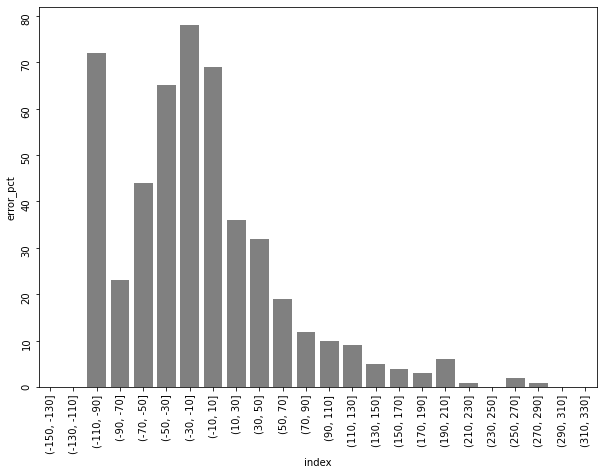

In [107]:
fig ,ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(data=pd.cut(holdout_res['error_pct'], bins=np.arange(-150,350,20)).value_counts().reset_index(), x='index', y='error_pct', ax=ax, color='grey')
ax.tick_params(labelrotation=90)

# Our model seems to be a bit too optimistic on the prediction as can be seen from the right skew shape below

Practical evaluation:

Idealy, we'd like to calculate uplift and ROI for each person in order to determine whether each person should receive the promo or not.

However, calculating baseline sales would be adding over-complexity to this project thus, I decided to use completion rates of selected users vs all users 

In [112]:
for col in ['person', 'avg_sales_norm', 'trans_count','trans_per_hr', 'trans_pro_ratio', 'y_reward', 'y_difficulty', 'y_duration']:
    holdout_res[col] = holdout_x[col].values
# holdout_res['actual_end_time'] = holdout_y['actual_end_time'].values
# holdout_res['latest_r_time'] = holdout_y['latest_r_time'].values
# holdout_res['time_spent_on_pro'] = holdout_res['actual_end_time']-holdout_res['latest_r_time'] 
# holdout_res['baseline_sales'] = holdout_res['time_spent_on_pro'] * holdout_res['trans_per_hr'] * (1-holdout_res['trans_pro_ratio']) * holdout_res['avg_sales_norm']
holdout_res['should_sent'] = np.where(holdout_res['predict']>=holdout_res['y_difficulty'], 1,0)
holdout_res['is_completed'] = np.where(holdout_res['actual']>=holdout_res['y_difficulty'], 1,0)
holdout_res.tail(10)

,actual,predict,error,error_pct,person,avg_sales_norm,trans_count,trans_per_hr,trans_pro_ratio,y_reward,y_difficulty,y_duration,should_sent,is_completed
490,43.76,14.8210,28.9390,195.256730,ffda4545e7084ff6aaf01304fb1c1fa6,0.000000,1.0,0.004167,0.000000,2.0,10.0,10.0,1,1
491,13.43,40.9592,-27.5292,-67.211274,ffdefcac307f4ca99ac1ebd51470f106,10.050000,6.0,0.015625,0.333333,5.0,5.0,7.0,1,1
492,0.00,33.1907,-33.1907,-100.000000,ffe5257abf8840b395e1ee6b29894637,34.950000,2.0,0.012821,0.500000,3.0,7.0,7.0,1,0
493,16.57,25.2825,-8.7125,-34.460595,ffeaa02452ef451082a0361c3ca62ef5,16.652500,7.0,0.020833,0.428571,0.0,0.0,0.0,1,1
494,9.08,4.7567,4.3233,90.888641,ffede3b700ac41d6a266fa1ba74b4f16,2.180000,5.0,0.017730,0.800000,5.0,5.0,5.0,0,1
495,13.72,23.4122,-9.6922,-41.398075,fff29fb549084123bd046dbc5ceb4faa,29.264000,7.0,0.027132,0.285714,2.0,10.0,10.0,1,1
496,432.14,24.7412,407.3988,1646.641230,fff3ba4757bd42088c044ca26d73817a,18.265714,8.0,0.025641,0.125000,10.0,10.0,5.0,1,1
497,10.09,5.4773,4.6127,84.214850,fff7576017104bcc8677a8d63322b5e1,0.000000,3.0,0.012500,0.000000,0.0,0.0,3.0,1,1
498,12.18,15.9274,-3.7474,-23.528008,fffad4f4828548d1b5583907f2e9906b,6.340000,8.0,0.021858,0.250000,3.0,7.0,7.0,1,1
499,17.55,26.4017,-8.8517,-33.527008,ffff82501cea40309d5fdd7edcca4a07,14.965000,9.0,0.027778,0.333333,5.0,5.0,5.0,1,1


In [114]:
print(f"Based on predicted data we should sent promotion to {holdout_res[holdout_res['should_sent']==1].shape[0]}\nThe completion rate is: {holdout_res.loc[holdout_res['should_sent']==1,'is_completed'].mean():.4f}")
print(f"Comparing to sending to all members in this holdout set of {holdout_res.shape[0]} which yield: {holdout_res['is_completed'].mean():.4f}")


Based on predicted data we should sent promotion to 393
The completion rate is: 0.8270
Comparing to sending to all members in this holdout set of 500 which yield: 0.6980


In [116]:
100*holdout_res.pivot_table(index=['should_sent'], columns=['is_completed'], values=['person'], aggfunc={'person':'count'})/holdout_res.shape[0]

person      
is_completed      0     1
should_sent              
0              16.6   4.8
1              13.6  65.0

The model show approximately 13% improvement comparing to sending it all to all members. 

Let's try this model on test set

In [138]:
def prep_x_data(y_df):
    x_test = pd.DataFrame()
    for idx, row_dat in tqdm(y_df.iterrows()):
        if idx==0:
            x_test = get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])
        else:
            x_test = pd.concat([x_test, get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])], axis=0)
    x_test = x_test.fillna(0)
    x_test['trans_count'] = x_test[['tnp_count','tp_count']].sum(axis=1)
    x_test['trans_per_hr'] = x_test['trans_count']/x_train['time_spent']
    x_test['trans_per_hr'] = np.where(x_test['trans_per_hr']==float('inf'),min(x_test['trans_per_hr']),x_test['trans_per_hr'])
    return x_test

def xy_data_pipeline(x_df, y_df):
    workable_set = set(x_df['person'].values).intersection(set(y_df['person'].values))
    workable_set = list(workable_set)
    len(workable_set)
    x_df = x_df[x_df['person'].isin(workable_set)]
    y_df = y_df[y_df['person'].isin(workable_set)]

    x_df = x_df.sort_values('person')
    y_df = y_df.sort_values('person')
    # x_train.head()
    for col in [col for col in y_df.columns if col not in ['person', 'valid_until','latest_r_time', 'sales_through_pro','actual_end_time']]:
        x_df[f'y_{col}'] = y_df[col]
    x_df = x_df.fillna(0)
    return x_df, y_df
    
def get_xy_data(raw_df, is_train):
    y_df = prepare_y_data(raw_df=raw_df, is_train=is_train)
    x_df = prep_x_data(y_df=y_df)
    x_df_final, y_df_final = xy_data_pipeline(x_df, y_df)
    return x_df_final, y_df_final


In [143]:
x_test, y_test = get_xy_data(raw_df=test_df, is_train=0)

In [118]:
y_test = prepare_y_data(raw_df=test_df, is_train=0)
y_test.head()

,person,latest_r_time,total_offer_received_count,reward,difficulty,duration,email,mobile,social,web,valid_until,actual_end_time,reward_input_ratio,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,pro_informational-0-0-4,sales_through_pro
0,0009655768c64bdeb2e877511632db8f,576,1,2,10,7,1,1,0,1,744,576.0,0.2,0,0,0,0,0,1,0,0,0,0,10.27
1,00116118485d4dfda04fdbaba9a87b5c,576,1,5,5,5,1,1,1,1,696,696.0,1.0,0,0,1,0,0,0,0,0,0,0,0.00
2,00426fe3ffde4c6b9cb9ad6d077a13ea,576,1,2,10,7,1,1,0,1,744,744.0,0.2,0,0,0,0,0,1,0,0,0,0,5.94
3,004b041fbfe44859945daa2c7f79ee64,576,1,2,10,10,1,1,1,1,816,714.0,0.2,0,0,0,0,1,0,0,0,0,0,19.93
4,005500a7188546ff8a767329a2f7c76a,576,1,10,10,7,1,1,1,0,744,744.0,1.0,0,1,0,0,0,0,0,0,0,0,10.65


In [ ]:
%%script False
x_test = pd.DataFrame()
for idx, row_dat in tqdm(y_test.iterrows()):
    if idx==0:
        x_test = get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])
    else:
        x_test = pd.concat([x_test, get_hist_full_data(row_dat['person'], row_dat['latest_r_time'])], axis=0)
x_test = x_test.fillna(0)
x_test['trans_count'] = x_test[['tnp_count','tp_count']].sum(axis=1)
x_test['trans_per_hr'] = x_test['trans_count']/x_test['time_spent']
x_test['trans_per_hr'] = np.where(x_test['trans_per_hr']==float('inf'),min(x_test['trans_per_hr']),x_test['trans_per_hr'])

In [136]:
# x_test.to_csv('x_test_saved.csv', index=False)
x_test = pd.read_csv('x_test_saved.csv')

In [122]:
x_test.head()

,person,received_offer_counts,viewed_rates,completed_rates,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,time_spent,avg_sales_norm,avg_sales_pro,tnp_count,tp_count,trans_pro_ratio,trans_count,trans_per_hr,have_pi,gen_F,gen_M,gen_O,gen_UN,age_0-20,age_21-40,age_41-60,age_61-80,age_80+,inc_0-20k,inc_20-40k,inc_40-60k,inc_60-80k,inc_80-100k,inc_100-120k,mem_2013,mem_2014,mem_2015,mem_2016,mem_2017,mem_2018
0,0009655768c64bdeb2e877511632db8f,3,0.666667,0.333333,0,0,0,0,0,1,0,0,1,348,12.646667,15.3650,3.0,2.0,0.400000,5.0,0.014368,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
0,00116118485d4dfda04fdbaba9a87b5c,1,1.000000,0.000000,0,0,1,0,0,0,0,0,0,180,1.363333,0.0000,3.0,0.0,0.000000,3.0,0.016667,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
0,00426fe3ffde4c6b9cb9ad6d077a13ea,4,0.500000,0.250000,0,0,0,0,1,1,0,1,1,450,2.218333,6.1575,6.0,8.0,0.571429,14.0,0.031111,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
0,004b041fbfe44859945daa2c7f79ee64,2,0.500000,0.500000,0,0,1,0,0,0,0,0,0,516,22.627500,27.9200,4.0,1.0,0.200000,5.0,0.009690,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
0,005500a7188546ff8a767329a2f7c76a,3,0.666667,0.000000,0,2,0,0,0,1,0,0,0,60,0.000000,4.8550,0.0,2.0,1.000000,2.0,0.033333,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [123]:
workable_set = set(x_test['person'].values).intersection(set(y_test['person'].values))
workable_set = list(workable_set)
print(len(workable_set))
x_test = x_test[x_test['person'].isin(workable_set)]
y_test = y_test[y_test['person'].isin(workable_set)]

x_test = x_test.sort_values('person')
y_test = y_test.sort_values('person')
# x_train.head()
for col in [col for col in y_test.columns if col not in ['person', 'valid_until','latest_r_time', 'sales_through_pro','actual_end_time']]:
    x_test[f'y_{col}'] = y_test[col]
x_test = x_test.fillna(0)
x_test.head()

9478


,person,received_offer_counts,viewed_rates,completed_rates,pro_bogo-10-10-5,pro_bogo-10-10-7,pro_bogo-5-5-5,pro_bogo-5-5-7,pro_discount-2-10-10,pro_discount-2-10-7,pro_discount-3-7-7,pro_discount-5-20-10,pro_informational-0-0-3,time_spent,avg_sales_norm,avg_sales_pro,tnp_count,tp_count,trans_pro_ratio,trans_count,trans_per_hr,have_pi,gen_F,gen_M,gen_O,gen_UN,age_0-20,age_21-40,age_41-60,age_61-80,age_80+,inc_0-20k,inc_20-40k,inc_40-60k,inc_60-80k,inc_80-100k,inc_100-120k,mem_2013,mem_2014,mem_2015,mem_2016,mem_2017,mem_2018,y_total_offer_received_count,y_reward,y_difficulty,y_duration,y_email,y_mobile,y_social,y_web,y_reward_input_ratio,y_pro_bogo-10-10-5,y_pro_bogo-10-10-7,y_pro_bogo-5-5-5,y_pro_bogo-5-5-7,y_pro_discount-2-10-10,y_pro_discount-2-10-7,y_pro_discount-3-7-7,y_pro_discount-5-20-10,y_pro_informational-0-0-3,y_pro_informational-0-0-4
0,0009655768c64bdeb2e877511632db8f,3,0.666667,0.333333,0,0,0,0,0,1,0,0,1,348,12.646667,15.3650,3.0,2.0,0.400000,5.0,0.014368,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,2,10,7,1,1,0,1,0.2,0,0,0,0,0,1,0,0,0,0
0,00116118485d4dfda04fdbaba9a87b5c,1,1.000000,0.000000,0,0,1,0,0,0,0,0,0,180,1.363333,0.0000,3.0,0.0,0.000000,3.0,0.016667,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,10,7,1,1,0,1,0.2,0,0,0,0,0,1,0,0,0,0
0,00426fe3ffde4c6b9cb9ad6d077a13ea,4,0.500000,0.250000,0,0,0,0,1,1,0,1,1,450,2.218333,6.1575,6.0,8.0,0.571429,14.0,0.031111,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,2,10,7,1,1,0,1,0.2,0,0,0,0,0,1,0,0,0,0
0,004b041fbfe44859945daa2c7f79ee64,2,0.500000,0.500000,0,0,1,0,0,0,0,0,0,516,22.627500,27.9200,4.0,1.0,0.200000,5.0,0.009690,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,10,7,1,1,0,1,0.2,0,0,0,0,0,1,0,0,0,0
0,005500a7188546ff8a767329a2f7c76a,3,0.666667,0.000000,0,2,0,0,0,1,0,0,0,60,0.000000,4.8550,0.0,2.0,1.000000,2.0,0.033333,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,2,10,7,1,1,0,1,0.2,0,0,0,0,0,1,0,0,0,0


In [124]:
# refitting the model because last time we did it without holdout set
test_scaler = MinMaxScaler()
scaled_train_x = test_scaler.fit_transform(x_train.drop(columns=['person']))
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(scaled_train_x, y_train['sales_through_pro'])
y_test_pred = rf_model.predict(test_scaler.transform(x_test.drop(columns=['person'])))

In [125]:
# evaluation

error = []
for actual, pred in zip(y_test['sales_through_pro'].values, y_test_pred):
    error.append(abs(actual-pred))

print(f"Averages sales actual: {np.mean(y_test['sales_through_pro'].values):.2f}")
print(f"Averages sales predict: {np.mean(y_test_pred):.2f}")
print(f"Mean absolute error: {np.mean(error):.2f}")
# np.mean(error)

Averages sales actual: 14.00
Averages sales predict: 18.45
Mean absolute error: 12.03


,actual,predict,error,error_pct,person,avg_sales_norm,trans_count,trans_per_hr,trans_pro_ratio,y_reward,y_difficulty,y_duration,should_sent,is_completed
9473,13.32,18.7723,-5.4523,-29.044390,ffe5257abf8840b395e1ee6b29894637,34.950000,2.0,0.012821,0.500000,2,10,7,1,1
9474,7.25,9.2937,-2.0437,-21.990165,ffede3b700ac41d6a266fa1ba74b4f16,2.005000,6.0,0.011905,0.666667,2,10,7,0,0
9475,47.50,10.6487,36.8513,346.063839,fff0f0aac6c547b9b263080f09a5586a,17.350000,4.0,0.009259,0.000000,2,10,7,1,1
9476,39.59,34.2050,5.3850,15.743312,fff29fb549084123bd046dbc5ceb4faa,28.348571,10.0,0.024876,0.300000,2,10,7,1,1
9477,8.01,8.3472,-0.3372,-4.039678,fff7576017104bcc8677a8d63322b5e1,0.000000,4.0,0.007663,1.000000,2,10,7,0,0


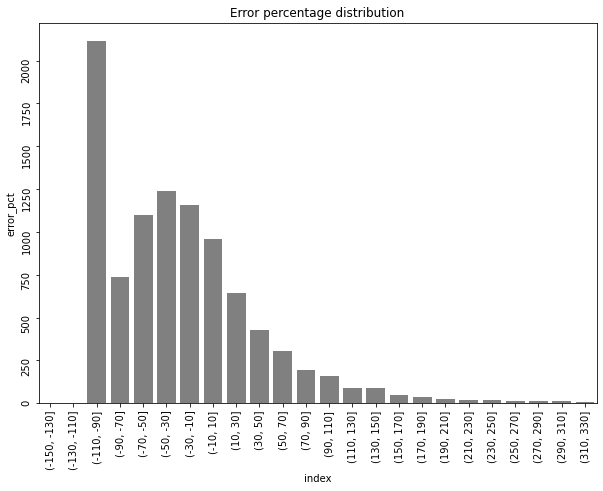

In [142]:
test_res = pd.DataFrame(zip(y_test['sales_through_pro'].values, y_test_pred), columns=['actual', 'predict'])
test_res['error'] = test_res['actual'] - test_res['predict'] 
test_res['error_pct'] = 100*test_res['error']/test_res['predict'] 
fig ,ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(data=pd.cut(test_res['error_pct'], bins=np.arange(-150,350,20)).value_counts().reset_index(), x='index', y='error_pct', ax=ax, color='grey')
ax.tick_params(labelrotation=90)
ax.set_title('Error percentage distribution')


for col in ['person', 'avg_sales_norm', 'trans_count','trans_per_hr', 'trans_pro_ratio', 'y_reward', 'y_difficulty', 'y_duration']:
    test_res[col] = x_test[col].values
# holdout_res['actual_end_time'] = holdout_y['actual_end_time'].values
# holdout_res['latest_r_time'] = holdout_y['latest_r_time'].values
# holdout_res['time_spent_on_pro'] = holdout_res['actual_end_time']-holdout_res['latest_r_time'] 
# holdout_res['baseline_sales'] = holdout_res['time_spent_on_pro'] * holdout_res['trans_per_hr'] * (1-holdout_res['trans_pro_ratio']) * holdout_res['avg_sales_norm']
test_res['should_sent'] = np.where(test_res['predict']>=test_res['y_difficulty'], 1,0)
test_res['is_completed'] = np.where(test_res['actual']>=test_res['y_difficulty'], 1,0)
test_res.tail(5)


In [128]:
print(f"Based on predicted data we should sent promotion to {test_res[test_res['should_sent']==1].shape[0]}\nThe completion rate is: {test_res.loc[test_res['should_sent']==1,'is_completed'].mean():.4f}")
print(f"Comparing to sending to all members in this test set of {test_res.shape[0]} which yield: {test_res['is_completed'].mean():.4f}")


Based on predicted data we should sent promotion to 6298
The completion rate is: 0.6728
Comparing to sending to all members in this holdout set of 9478 which yield: 0.4883


In [129]:
100*test_res.pivot_table(index=['should_sent'], columns=['is_completed'], values=['person'], aggfunc={'person':'count'})/test_res.shape[0]

person           
is_completed          0          1
should_sent                       
0             29.426039   4.125343
1             21.745094  44.703524

Completion rate using our models also perform much better than sending it to all users. The rates are still quite low comparing to holdout set. 

Probably due to the fact that in test set we take latest promo received and, some of them are still active. Thus, the result are not casted in stone as of now

In [134]:
# Latest sales transaction we have
sales_trans['time'].max()

714

In [135]:
# Valid until time of the promo we predicted on test set
test_df.valid_until.value_counts().sort_index(ascending=False).head(15)

# Our hypothesis does have a point

816    2051
744    3900
696    1944
672    1077
648    1058
Name: valid_until, dtype: int64

### Reflection

On this project, I aim to use data provided from Starbucks to get insight on promotion and, give suggestion on whether we should send out the promotion to the users or not.

I found that:
- If user is aware of the promotions, they're more inclined to complete the challenge
- Being aware of the promotions doesn't increase there spending but, it does increase frequencies. Even if it just a informational campaign

On model side, I tried to predict how much a person would spend a campaign if they were to receive it. The error is quite high. However, if we use the output as a expected sales and compare with difficulty to check whether the person would complete the campaign or not. Then we only sent to those who're likely to complete the campaign. It increases the completion rates by 13% and 20% on holdout set and test set respectively. Which is quite a huge gap.

In term of improvements:
- In more corporate environment, we should create a pipeline with incremental update on data similar to x_train. This will help speed up the pipeline by a lot
- Baseline sales should be used to calculated ROI and Uplift for metrics instead of completion rates